In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
        
#Scaling and Splitting
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler
from sklearn.model_selection import train_test_split

#Modeling
from sklearn.linear_model import LassoLars
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

#Evaluation
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.metrics import mean_absolute_error,r2_score,mean_squared_error

/kaggle/input/trailer-prices/trailerdata1.csv


# About this notebook
This notebook aims to predict the price of a product (trailer) for an early stage start-up. The data has been anonymized. Due to the web infrastructure of other manufacturers of similar trailers, the data was collected by hand. This project is still on-going and updated regularly. 

## Current Challenges
Currently the challenge is to deal with the small amount of data. There are unfortunately not many data points availbale in general, but work is underway to fill in vital details of partially filled entries to increase the entries which actually get used in ML modeling. 

In [2]:
#The trailer price data is saved in a csv file and must first be loaded
data = pd.read_csv('/kaggle/input/trailer-prices/trailerdata1.csv', sep=';')
data.head(5)

,total dry weight,sleeps,length,exterior width,exterior height,interior height,price
0,1660.0,2.0,198,102,84.0,54.0,14879.0
1,2260.0,3.0,194,102,108.0,74.0,18489.0
2,1320.0,2.0,144,102,90.0,54.0,12500.0
3,1320.0,2.0,144,102,90.0,54.0,14997.0
4,1930.0,3.0,185,102,105.0,73.0,15965.0


In [3]:
#inspect the data types of each column
#for modeling everything needs to be and int or float
data.dtypes

total dry weight    float64
sleeps              float64
length                int64
exterior width        int64
exterior height     float64
interior height     float64
price               float64
dtype: object

In [4]:
#checking for missing values
#missing values must be dealt with for ML modeling
data.isna().sum()

total dry weight     4
sleeps              43
length               0
exterior width       0
exterior height      8
interior height      8
price                1
dtype: int64

For modeling all rows and columns must contain data to be considered "clean". There are numerous empty rows which will be dealt with in various ways coming up.

In [5]:
# drop redundant index
#data.drop('Unnamed: 0', axis = 1, inplace = True)

In [6]:
#drop columns which contain many empty values that are unlikely to be helpful in calculations
#notice there are still NaN values after this which must be dealt with still
#data.drop(['model', 'year', 'sleeps', 'aluminum siding (inch)', 'A/C', 'msrp'], axis=1)

In [7]:
#currently "sleeps" has many missing values so it will be removed
#needs to be added back later
data = data.drop(['sleeps'], axis=1)

In [8]:
data

,total dry weight,length,exterior width,exterior height,interior height,price
0,1660.0,198,102,84.0,54.0,14879.0
1,2260.0,194,102,108.0,74.0,18489.0
2,1320.0,144,102,90.0,54.0,12500.0
3,1320.0,144,102,90.0,54.0,14997.0
4,1930.0,185,102,105.0,73.0,15965.0
5,2260.0,194,102,108.0,74.0,18689.0
6,720.0,144,48,64.0,46.0,5500.0
7,820.0,144,60,64.0,46.0,6500.0
8,820.0,144,60,64.0,46.0,6999.0
9,999.0,144,60,64.0,46.0,7999.0


In [9]:
#some rows just don't have enough data, so these will simply be dropped for now
#double check websites to look for more data
data1=data.drop(data.index[[14,15,16,21,22,23,29, 30, 52]])

In [10]:
data1

,total dry weight,length,exterior width,exterior height,interior height,price
0,1660.0,198,102,84.0,54.0,14879.0
1,2260.0,194,102,108.0,74.0,18489.0
2,1320.0,144,102,90.0,54.0,12500.0
3,1320.0,144,102,90.0,54.0,14997.0
4,1930.0,185,102,105.0,73.0,15965.0
5,2260.0,194,102,108.0,74.0,18689.0
6,720.0,144,48,64.0,46.0,5500.0
7,820.0,144,60,64.0,46.0,6500.0
8,820.0,144,60,64.0,46.0,6999.0
9,999.0,144,60,64.0,46.0,7999.0


In [11]:
#42 dropped because its missing weight
#53 is the target
data2=data1.drop(data.index[[42,53]])

In [12]:
data2

,total dry weight,length,exterior width,exterior height,interior height,price
0,1660.0,198,102,84.0,54.0,14879.0
1,2260.0,194,102,108.0,74.0,18489.0
2,1320.0,144,102,90.0,54.0,12500.0
3,1320.0,144,102,90.0,54.0,14997.0
4,1930.0,185,102,105.0,73.0,15965.0
5,2260.0,194,102,108.0,74.0,18689.0
6,720.0,144,48,64.0,46.0,5500.0
7,820.0,144,60,64.0,46.0,6500.0
8,820.0,144,60,64.0,46.0,6999.0
9,999.0,144,60,64.0,46.0,7999.0


In [13]:
data2.isna().sum()

total dry weight    0
length              0
exterior width      0
exterior height     0
interior height     3
price               0
dtype: int64

In [14]:
data2.shape

(43, 6)

In [15]:
#data2 = data1.drop(['model', 'year', 'sleeps', 'aluminum siding (inch)', 'A/C', 'msrp', 'interior height'], axis=1)

In [16]:
#this column will be renamed because the space in the heading will cause errors ahead
data2 = data2.rename(columns={"exterior height": "eheight", "total dry weight": "tdweight", "interior height":"intheight"})

There are still 3 missing values, but it is missing because these trailers are small than all the others and actually don't have an interior to have an interior height. Therefore it makes the most sense to fill them all in with 0, as they must contain some number for modeling. 

In [17]:
#impute null values 
data2.intheight = data2.intheight.fillna(0)

In [18]:
data2

,tdweight,length,exterior width,eheight,intheight,price
0,1660.0,198,102,84.0,54.0,14879.0
1,2260.0,194,102,108.0,74.0,18489.0
2,1320.0,144,102,90.0,54.0,12500.0
3,1320.0,144,102,90.0,54.0,14997.0
4,1930.0,185,102,105.0,73.0,15965.0
5,2260.0,194,102,108.0,74.0,18689.0
6,720.0,144,48,64.0,46.0,5500.0
7,820.0,144,60,64.0,46.0,6500.0
8,820.0,144,60,64.0,46.0,6999.0
9,999.0,144,60,64.0,46.0,7999.0


In [19]:
data2.isna().sum()

tdweight          0
length            0
exterior width    0
eheight           0
intheight         0
price             0
dtype: int64

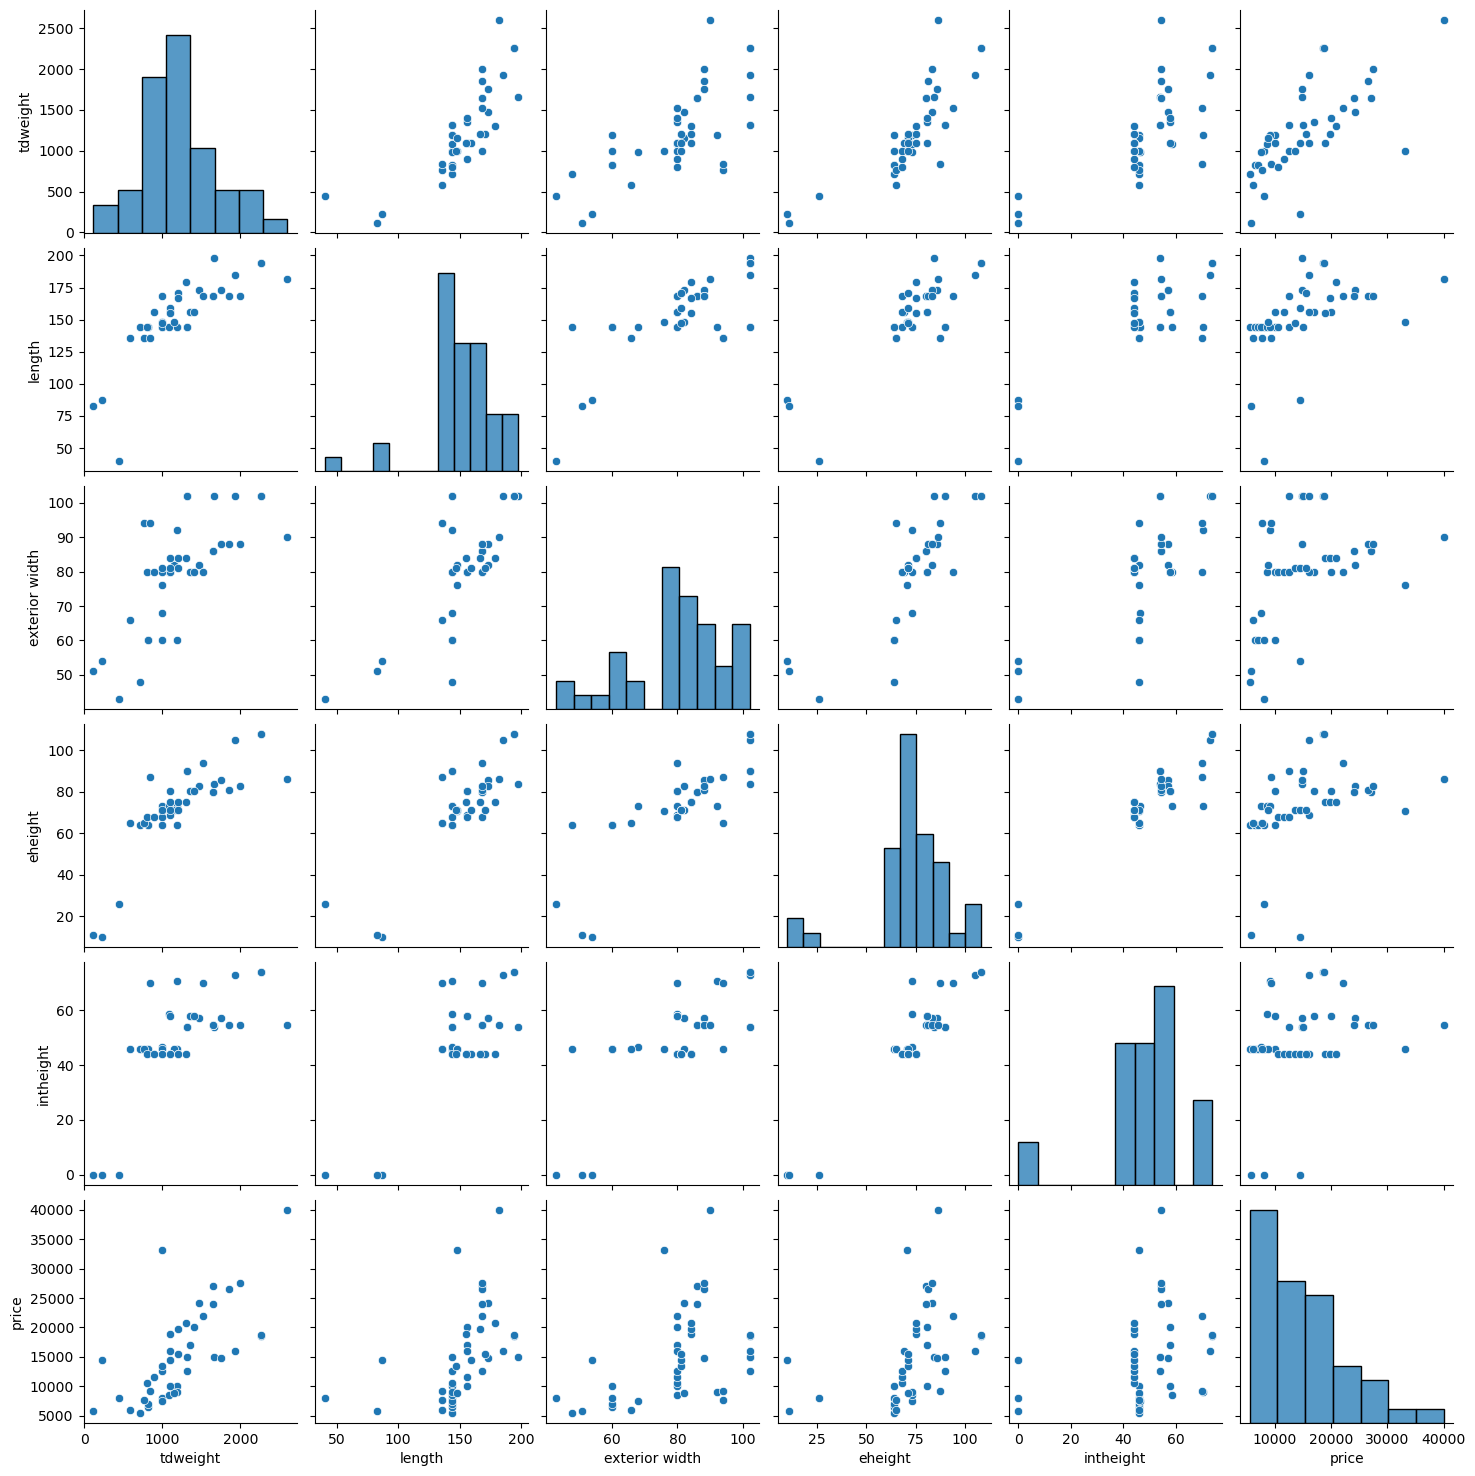

In [20]:
sns.pairplot(data2)

Of all the variables, total dry weight appears to be the most correlated with the price. Let's look at it a bit more closely. 

Text(0.5, 0, 'Price ($)')

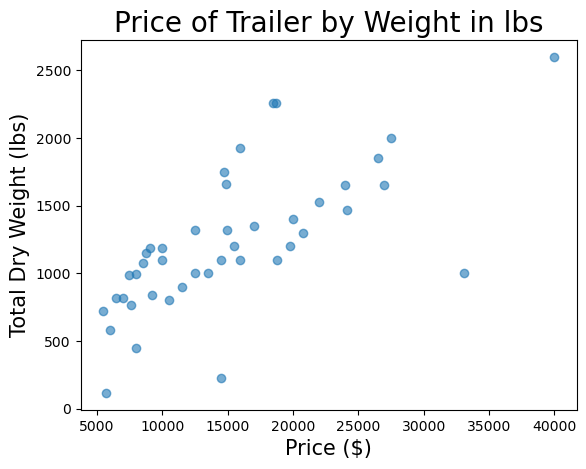

In [21]:
x="price"
y= "tdweight"
plt.scatter(x, y, data=data2, alpha=0.6);
plt.title("Price of Trailer by Weight in lbs", fontsize=20)
plt.ylabel("Total Dry Weight (lbs)", fontsize=15)
plt.xlabel("Price ($)", fontsize=15)
#highlight last point

In [22]:
corr=data2.corr()
corr

,tdweight,length,exterior width,eheight,intheight,price
tdweight,1.000000,0.790244,0.701607,0.807714,0.704815,0.688528
length,0.790244,1.000000,0.703991,0.843449,0.788973,0.486374
exterior width,0.701607,0.703991,1.000000,0.802149,0.722088,0.410377
eheight,0.807714,0.843449,0.802149,1.000000,0.939800,0.393313
intheight,0.704815,0.788973,0.722088,0.939800,1.000000,0.268009
price,0.688528,0.486374,0.410377,0.393313,0.268009,1.000000


<AxesSubplot:>

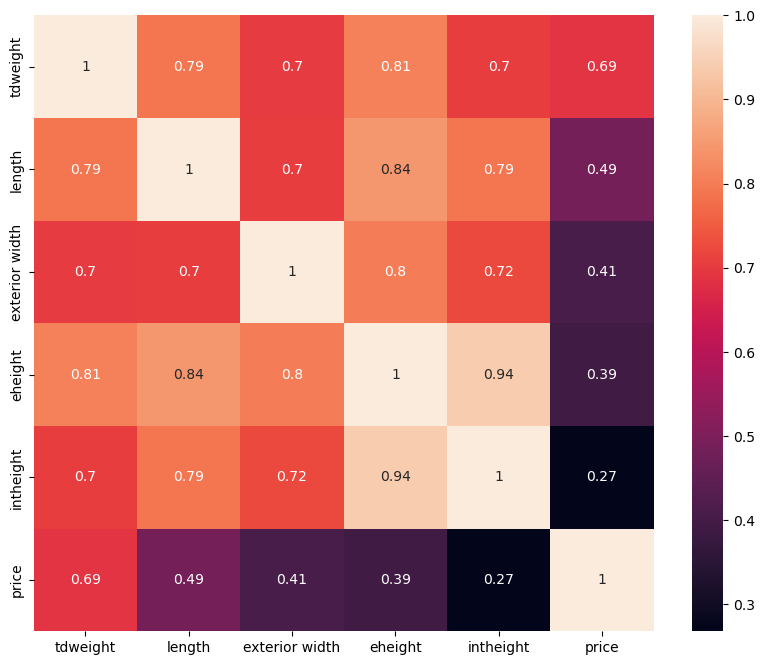

In [23]:
plt.figure(figsize=(10,8))
sns.heatmap(corr,annot=True)

# Machine Learning Modeling
The data is now clean and we can move forward with creating some machine learning models. Once we settle on the best model it can be used to predict the target price of the trailer in question.

In [24]:
#here the data is split up into X,y where X contains everything but price and y contains what we want to predict (price)
#price is what we want to predict
X = data2.drop(['price'],axis=1)
y=data2['price']

In [25]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=1)

In [26]:
#scaling the data
#this usually helps with modeling
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [27]:
#function which runs different ML models and prints R^2, MAE and RMSE
def run_experiment(model):
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    print("R^2 : ", r2_score(y_test, y_pred))
    print("MAE :", mean_absolute_error(y_test,y_pred))
    print("RMSE:",np.sqrt(mean_squared_error(y_test, y_pred)))

Now the data is all cleaned up and ready for creating some machine learning models. A funtion has been written to run various models and output metrics 

In [28]:
model_1 = LinearRegression()
run_experiment(model_1)

R^2 :  0.5922049944508987
MAE : 3444.82783107073
RMSE: 4047.366280622188


In [29]:
model_2 = DecisionTreeRegressor(random_state = 1)
run_experiment(model_2)

R^2 :  0.018025454306422994
MAE : 5398.454545454545
RMSE: 6280.60778399381


In [30]:
model_3 = Ridge(alpha=100, solver='cholesky', tol=0.0001, random_state=1)
run_experiment(model_3)

R^2 :  0.3471203120770806
MAE : 4590.035400227888
RMSE: 5121.157545991203


In [31]:
model_4 = Lasso(alpha=0.1, precompute=True, positive=True, selection='random', random_state=1)
run_experiment(model_4)

R^2 :  0.6940899614916273
MAE : 2934.0074942959995
RMSE: 3505.487495615267


In [32]:
model_5 = ElasticNet(alpha=0.1, l1_ratio=0.9, selection='random', random_state=1)
run_experiment(model_5)

R^2 :  0.5946132123034757
MAE : 3448.765378883092
RMSE: 4035.397801002883


In [33]:
model_6 = LassoLars(alpha=.1)
run_experiment(model_6)

R^2 :  0.5923765816426964
MAE : 3444.3373474938953
RMSE: 4046.5146894138884


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_base.py:138: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLars())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,


In [34]:
model_7 = BayesianRidge()
run_experiment(model_7)

R^2 :  0.5953995474269048
MAE : 3607.0085663282593
RMSE: 4031.4821389945837


In [35]:
model_8 = SGDRegressor(max_iter=1000, tol=1e-3)
run_experiment(model_8)

R^2 :  0.5946470011200042
MAE : 3502.897448629494
RMSE: 4035.229623152272


In [36]:
model_9 = SVR(epsilon=0.2)
run_experiment(model_9)

R^2 :  -0.0022214690477357912
MAE : 5461.094322687134
RMSE: 6345.026040322149


In [37]:
model_10 = RandomForestRegressor(n_estimators=100, min_samples_leaf=3, random_state=1)
run_experiment(model_10)

R^2 :  0.7731748188377794
MAE : 2416.972607044471
RMSE: 3018.5417785528616


In [38]:
#import hvplot.pandas
#pd.data2({'True Values': y_test, 'Predicted Values': pred}).hvplot.scatter(x='True Values', y='Predicted Values')

Unsurprisingly, RandomForest preformed better than all the other models tested. Therefore we will move forward with tuning hyperparameters to figure out which produce the best result.

## Hyperparameter Tuning
Perhaps it is a bit early to get into hyperparameter tuning, but nonetheless the code is ready for once the dataset has been expanded :)

In [39]:
rfc=RandomForestRegressor(random_state=1)

In [40]:
param_grid = { 
    'n_estimators': [100, 500, 1000, 5000],
    'max_features': ['auto', 'sqrt', 'log2'],
    #to save time in updating the notebook, max_depth is also left out
    'max_depth' : [5, 10, 15],
    'min_samples_leaf' : [1,2,3,5],
    #'criterion' :['squared_error', 'absolute_error', 'friedman_mse']
}


In [41]:
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=1),
             param_grid={'max_depth': [5, 10, 15],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 3, 5],
                         'n_estimators': [100, 500, 1000, 5000]})

In [42]:
#print the best parameters determined in GridSearchCV
CV_rfc.best_params_

{'max_depth': 5,
 'max_features': 'sqrt',
 'min_samples_leaf': 5,
 'n_estimators': 100}

In [43]:
#run a final model using the optimal parameters
final_model = RandomForestRegressor(n_estimators=100, max_features='sqrt', max_depth=5, min_samples_leaf=5, random_state=1)
run_experiment(final_model)

R^2 :  0.7874191538915882
MAE : 2691.0452126211403
RMSE: 2922.224809603155


In [44]:
new_input = data.iloc[53:54]
new_input

,total dry weight,length,exterior width,exterior height,interior height,price
53,850.0,144,93,72.0,47.0,9995.0


In [45]:
new_input=new_input.drop(['price'],axis=1)

In [46]:
new_output = final_model.predict(new_input)
new_output

/opt/conda/lib/python3.7/site-packages/sklearn/base.py:444: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


array([21910.19300586])

# Notes on the metrics used
✔️ Regression Evaluation Metrics
Here are three common evaluation metrics for regression problems:

Mean Absolute Error (MAE) is the mean of the absolute value of the errors:
1𝑛∑𝑖=1𝑛|𝑦𝑖−𝑦̂𝑖|
1
n
∑
i
=
1
n
|
y
i
−
y
^
i
|
 

 
Mean Squared Error (MSE) is the mean of the squared errors:
1𝑛∑𝑖=1𝑛(𝑦𝑖−𝑦̂𝑖)2
1
n
∑
i
=
1
n
(
y
i
−
y
^
i
)
2
 
Root Mean Squared Error (RMSE) is the square root of the mean of the squared errors:
1𝑛∑𝑖=1𝑛(𝑦𝑖−𝑦̂𝑖)2‾‾‾‾‾‾‾‾‾‾‾‾‾‾⎷
1
n
∑
i
=
1
n
(
y
i
−
y
^
i
)
2
 
📌 Comparing these metrics:

MAE is the easiest to understand, because it's the average error.
MSE is more popular than MAE, because MSE "punishes" larger errors, which tends to be useful in the real world.
RMSE is even more popular than MSE, because RMSE is interpretable in the "y" units.
All of these are loss functions, because we want to minimize them.

https://www.kaggle.com/code/faressayah/practical-introduction-to-10-regression-algorithm?scriptVersionId=117768677&cellId=36

<iframe src="https://www.kaggle.com/embed/faressayah/practical-introduction-to-10-regression-algorithm?cellIds=36&kernelSessionId=117768677" height="300" style="margin: 0 auto; width: 100%; max-width: 950px;" frameborder="0" scrolling="auto" title="Practical Introduction to 10 Regression Algorithm"></iframe>